In [193]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import roc_curve, accuracy_score, confusion_matrix, recall_score, precision_score
# matplotlib 한글 폰트 오류 문제 해결
# font_manager는 경로와 이름을 가지고 폰트를 지정
# rc는 폰트를 적용
from matplotlib import font_manager, rc
font_path = "./malgun.ttf"
font_name = font_manager.FontProperties(fname=font_path).get_name()
rc('font', family=font_name)

import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import SGD, Adam

from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard, ReduceLROnPlateau

In [194]:
df = pd.read_csv("./20202021data.csv", encoding = "euc-kr")


In [195]:
df.columns

Index(['Unnamed: 0', '회사명', '상장유지년도_2020(X1)', '2020 배당성향(X3)', '2020 배당률(X4)',
       '당기순손실여부_2020(X5)', '주당순이익감소여부_2020(X6)', '유동비율_전기(X7)', '부채비율_전기(X8)',
       '총자산증가율_전기(X10)', '매출액증가율_전기(X11)', '매출액순이익률_전기(X12)',
       '총자본영업이익률_전기(X13)', '자기자본순이익률_전기(X14)', '2020_외국인지분율(X17)',
       '외국인지분율변동_2020(X18)', '배당정책_2020(Y)'],
      dtype='object')

In [196]:
df = df[['상장유지년도_2020(X1)', '2020 배당성향(X3)', '2020 배당률(X4)',
       '당기순손실여부_2020(X5)', '주당순이익감소여부_2020(X6)', '유동비율_전기(X7)', '부채비율_전기(X8)',
       '총자산증가율_전기(X10)', '매출액증가율_전기(X11)', '매출액순이익률_전기(X12)',
       '총자본영업이익률_전기(X13)', '자기자본순이익률_전기(X14)', '2020_외국인지분율(X17)',
       '외국인지분율변동_2020(X18)', '배당정책_2020(Y)']]

# 표준화작업

In [199]:
# standard scaler 로 표준화
from sklearn.preprocessing import StandardScaler

InputFeature = df.iloc[:,:-1].values
Label = df.iloc[:, -1]

InputFeature = StandardScaler().fit_transform(InputFeature)

features = [  '상장유지년도(X1)', '배당성향(X2)', '배당률(X3)',
       '당기순손실여부(X4)', '주당순이익감소여부(X5)', '유동비율(X6)', '부채비율(X7)',
       '총자산증가율(X8)', '매출액증가율(X9)', '매출액순이익률(X10)',
       '총자본영업이익률(X11)', '자기자본순이익률(X12)', '외국인지분율(X13)',
       '외국인지분율변동(X14)']
df_st = pd.DataFrame(InputFeature, columns=features)
df_st.head()

,상장유지년도(X1),배당성향(X3),배당률(X4),당기순손실여부(X5),주당순이익감소여부(X6),유동비율(X7),부채비율(X8),총자산증가율(X10),매출액증가율(X11),매출액순이익률(X12),총자본영업이익률(X13),자기자본순이익률(X14),외국인지분율(X17),외국인지분율변동(X18)
0,-1.171724,1.888182,-0.181354,-0.329415,1.223209,-0.285763,4.480999,-0.645084,0.088754,-0.365530,-0.231848,-0.191291,0.233730,-1.118413
1,0.081638,-0.307974,-0.224765,-0.329415,1.223209,-0.302159,-0.550302,0.057682,0.489657,0.419517,-0.143512,-0.609845,0.016800,0.894124
2,-1.328394,-0.259579,-0.171336,-0.329415,-0.817522,-0.210338,2.021297,-1.196416,0.327123,-0.349727,1.164206,1.071846,0.229134,0.894124
3,-1.093389,0.116498,-0.214747,-0.329415,-0.817522,2.476984,-1.062963,-0.470094,0.713901,1.458809,-0.588656,-0.641878,-0.002503,0.894124
4,-1.328394,-0.070631,0.549950,-0.329415,1.223209,-0.251724,3.380465,-0.005135,-0.171778,-0.445940,0.272187,1.197839,2.078548,0.894124


In [200]:
Label[ : int(len(Label) * 0.6)]

0      0
1      0
2      1
3      0
4      0
      ..
393    1
394    0
395    0
396    1
397    0
Name: 배당정책_2020(Y), Length: 398, dtype: int64

In [201]:
# train valid test set 6 : 2 : 2로 나누기
train_x = df_st.iloc[:int(len(df_st) * 0.6), :]
train_y = Label[ : int(len(Label) * 0.6)]
valid_x = df_st.iloc[int(len(df_st) * 0.6) : int(len(df_st) * 0.8), :]
valid_y = Label[int(len(Label) * 0.6): int(len(Label) * 0.8)]
test_x = df_st.iloc[int(len(df_st) * 0.8) :, :]
test_y = Label[int(len(Label) * 0.8) : ]

In [202]:
print(train_x.shape)
print(train_y.shape)
print(valid_x.shape)
print(valid_y.shape)
print(test_x.shape)
print(test_y.shape)

(398, 14)
(398,)
(133, 14)
(133,)
(133, 14)
(133,)


In [203]:
# 신경망 모델 학습
model = Sequential()
model.add(Dense(7, activation='tanh', input_shape=(14,)))
model.add(Dense(3, activation='tanh'))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',optimizer=Adam(learning_rate=0.01), metrics=['binary_accuracy'])

hist = model.fit(x=train_x, y=train_y, epochs=20, shuffle=True, batch_size=3, validation_data=(valid_x, valid_y))

Epoch 1/20
133/133 [==============================] - 1s 3ms/step - loss: 0.5992 - binary_accuracy: 0.6759 - val_loss: 0.6433 - val_binary_accuracy: 0.6466
Epoch 2/20
133/133 [==============================] - 0s 2ms/step - loss: 0.5623 - binary_accuracy: 0.7236 - val_loss: 0.6421 - val_binary_accuracy: 0.6466
Epoch 3/20
133/133 [==============================] - 0s 2ms/step - loss: 0.5502 - binary_accuracy: 0.7362 - val_loss: 0.6511 - val_binary_accuracy: 0.6617
Epoch 4/20
133/133 [==============================] - 0s 2ms/step - loss: 0.5491 - binary_accuracy: 0.7236 - val_loss: 0.6624 - val_binary_accuracy: 0.6541
Epoch 5/20
133/133 [==============================] - 0s 2ms/step - loss: 0.5392 - binary_accuracy: 0.7412 - val_loss: 0.6483 - val_binary_accuracy: 0.6767
Epoch 6/20
133/133 [==============================] - 0s 2ms/step - loss: 0.5365 - binary_accuracy: 0.7487 - val_loss: 0.6444 - val_binary_accuracy: 0.6617
Epoch 7/20
133/133 [==============================] - 0s 2ms/ste

In [204]:
model.evaluate(test_x, test_y)

5/5 [==============================] - 0s 2ms/step - loss: 0.6837 - binary_accuracy: 0.6316


[0.6836896538734436, 0.6315789222717285]

In [207]:
test_y.value_counts()

0    74
1    59
Name: 배당정책_2020(Y), dtype: int64

In [223]:
from numpy import sqrt
from numpy import argmax
from sklearn.metrics import classification_report
from sklearn.metrics import plot_roc_curve

y_prob2 = model.predict(test_x)

# calculate roc curves
fpr, tpr, thresholds = roc_curve(test_y, y_prob2)
# best threshold 를 구하고 절단
# Youden’s J statistic. / J = Sensitivity + Specificity – 1
J = tpr - fpr
ix = argmax(J)
best_thresh = thresholds[ix]
print('Best Threshold=%f, sensitivity = %.3f, specificity = %.3f, J=%.3f' % (best_thresh, tpr[ix], 1-fpr[ix], J[ix]))

y_prob_pred = (y_prob2 >= best_thresh).astype(bool)
print(classification_report(test_y, y_prob_pred, target_names=['1', '0'], labels=[1, 0]))

Best Threshold=0.625776, sensitivity = 0.644, specificity = 0.770, J=0.414
              precision    recall  f1-score   support

      normal       0.73      0.77      0.75        74
    abnormal       0.69      0.64      0.67        59

    accuracy                           0.71       133
   macro avg       0.71      0.71      0.71       133
weighted avg       0.71      0.71      0.71       133



In [225]:
# confusion matrix 나타내기
confusion_matrix(test_y, y_prob_pred, labels=[1, 0])

array([[38, 21],
       [17, 57]], dtype=int64)

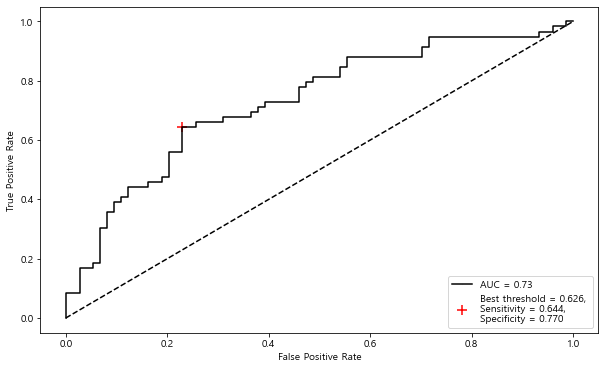

<Figure size 864x504 with 0 Axes>

In [227]:
# roc 커브 그리고 best threshold 지점 나타내기
import scikitplot as skplt
from sklearn.metrics import roc_auc_score

plt.figure(figsize=(10, 6))

#plot roc and best threshold
sens, spec = tpr[ix], 1-fpr[ix]
# plot the roc curve for the model
plt.plot([0,1], [0,1], linestyle='--', markersize=0.01, color='black')
plt.plot(fpr, tpr, marker='.', color='black', markersize=0.05, label="AUC = %.2f" % roc_auc_score(test_y, y_prob2))
plt.scatter(fpr[ix], tpr[ix], marker='+', s=100, color='r', 
            label='Best threshold = %.3f, \nSensitivity = %.3f, \nSpecificity = %.3f' % (best_thresh, sens, spec))

# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc=4)

plt.figure(figsize=(12, 7))

# show the plot
plt.show()

In [228]:
# 정확도 구하기
from sklearn.metrics import accuracy_score

accuracy_score(test_y, y_prob_pred)

0.7142857142857143

In [230]:
# auc 점수 구하기
from sklearn.metrics import roc_auc_score

print(roc_auc_score(test_y, model.predict(test_x)))

0.7304168575355016
